In [8]:
import numpy as np
import pickle
import torch
import matplotlib.pyplot as plt
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'

from egg.core.language_analysis import calc_entropy, _hashable_tensor

In [2]:
N = 20
vocab_size = 200

### training and test performance

In [38]:
def load_interaction(model, N, vocab_size, data='validation', run=0):
    
    path = ('N' + str(N) + '_vocab-size' + str(vocab_size) + '/0/interactions/' + data + 
            '/epoch_250/' + 'interaction_gpu0')
    logs = torch.load(path)
    return logs 

def one_hot_to_numbers(inputs):
    
    n_summands = 2
    N = inputs.shape[1]//n_summands
    numbers1 = inputs[:,0:N].argmax(axis=1)
    numbers2 = inputs[:,N:2*N].argmax(axis=1)
    numbers = torch.stack([numbers1, numbers2], axis=1)
    return numbers


def plot_accuracy_versus_frequency(logs):
    
    numbers = one_hot_to_numbers(logs.sender_input)
    messages = logs.message.argmax(dim=-1)
    receiver_output = torch.argmax(logs.receiver_output, dim=1)
    
    results = {'sum': [], 'frequency': [], 'accuracy': []}
    input_sums = torch.sum(numbers, axis=1)
    for sum_i in range(N + N):
        indices = torch.where(input_sums == sum_i)[0]
        if len(indices) > 0: 
            results['sum'].append(sum_i)
            results['frequency'].append(len(indices) / len(input_sums))
            accuracy = torch.mean((input_sums[indices] == receiver_output[indices]).float())
            results['accuracy'].append(accuracy)
    plt.scatter(results['frequency'], results['accuracy'])
    plt.xlabel('frequency')
    plt.ylabel('accuracy')
    

def plot_symbol_per_input(logs):
    
    numbers = one_hot_to_numbers(logs.sender_input)
    messages = logs.message.argmax(dim=-1)
    
    x = np.array(numbers[:, 0])
    y = np.array(numbers[:, 1])
    z = np.array(messages)
    n = len(x)
    image = np.zeros((N, N))

    for i in range(n):
        image[x[i],N-1-y[i]] = messages[i]

    plt.imshow(image, cmap='viridis')
    plt.yticks(ticks=[19, 14, 9, 4], labels=[0, 5, 10, 15])
    plt.xticks([0, 5, 10, 15])
    plt.show()
    

def joint_entropy(xs, ys):
    xys = []

    for x, y in zip(xs, ys):
        xy = (_hashable_tensor(x), _hashable_tensor(y))
        xys.append(xy)

    return calc_entropy(xys)


def information_scores(logs, N, normalizer="arithmetic"):
    """calculate entropy scores: mutual information (MI), polysemy, and synonymy
    """

    numbers = one_hot_to_numbers(logs.sender_input)
    sums = torch.sum(numbers, dim=1)
    messages = logs.message.argmax(dim=-1)
    
    H_sums = calc_entropy(sums)
    H_numbers = calc_entropy(numbers)
    H_messages = calc_entropy(messages)
    
    H_sums_messages = joint_entropy(sums, messages)
    H_numbers_messages = joint_entropy(numbers, messages)

    if normalizer == "arithmetic":
        normalizer_sums_messages = 0.5 * (H_sums + H_messages)
        normalizer_numbers_messages = 0.5 * (H_numbers + H_messages)
    elif normalizer == "joint":
        normalizer_sums_messages = H_sums_messages
        normalizer_numbers_messages = H_numbers_messages
    else:
        raise AttributeError("Unknown normalizer")

    # normalized mutual information
    NMI_sums_messages = (H_sums + H_messages - H_sums_messages) / normalizer_sums_messages
    NMI_numbers_messages = (H_numbers + H_messages - H_numbers_messages) / normalizer_numbers_messages

    # normalized conditional entropy H(input | messages) --> polysemy
    polysemy_numbers = (H_numbers_messages - H_messages) / H_numbers
    polysemy_sums = (H_sums_messages - H_messages) / H_sums

    # normalized conditional entropy H(messages | input) --> synonymy
    
    synonymy_numbers = (H_numbers_messages - H_numbers) / H_messages
    synonymy_sums = (H_sums_messages - H_sums) / H_messages
  

    score_dict = {'NMI_sums': NMI_sums_messages,
                  'NMI_numbers': NMI_numbers_messages,
                  'polysemy_sums': polysemy_sums,
                  'polysemy_numbers': polysemy_numbers, 
                  'synonymy_sums': synonymy_sums, 
                  'synonymy_numbers': synonymy_numbers}

    return score_dict
 
     
def calc_performance(logs):

    numbers = one_hot_to_numbers(logs.sender_input)
    messages = logs.message.argmax(dim=-1)
    receiver_output = logs.receiver_output.argmax(dim=1)
    
    accuracy = torch.mean((torch.sum(numbers, dim=1) == logs.receiver_output.argmax(dim=1)).float())
    abs_diff = torch.mean(torch.abs(logs.receiver_output.argmax(dim=1) - torch.sum(numbers, dim=1)).float())
    
    return accuracy, abs_diff

In [39]:
test_logs = load_interaction(None, 20, 200, data='train')

In [40]:
calc_performance(test_logs)

(tensor(0.9939), tensor(0.0102))

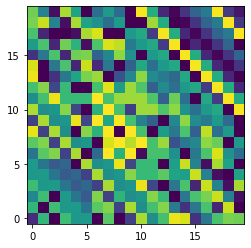

In [41]:
plot_symbol_per_input(test_logs)

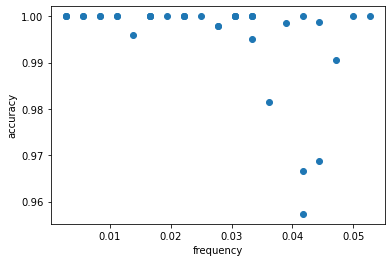

In [42]:
plot_accuracy_versus_frequency(test_logs)

In [43]:
information_scores(test_logs, N)

{'NMI_sums': 0.8755238576979001,
 'NMI_numbers': 0.830810416870747,
 'polysemy_sums': 0.02320032240546505,
 'polysemy_numbers': 0.2813235197023992,
 'synonymy_sums': 0.20672399668128322,
 'synonymy_numbers': 0.01559435134611193}